In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

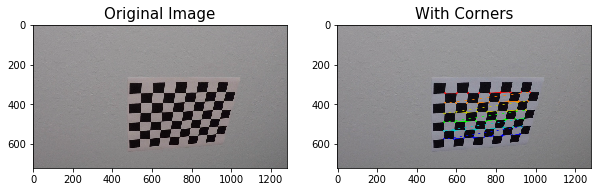

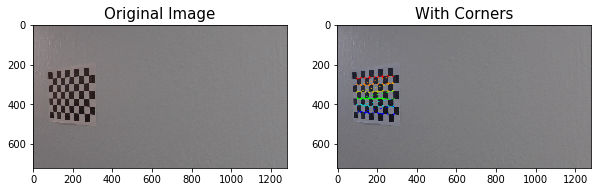

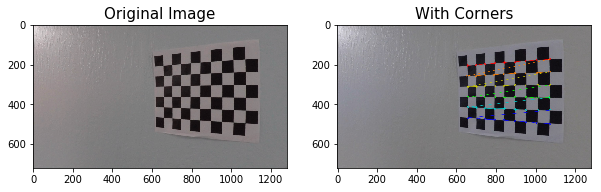

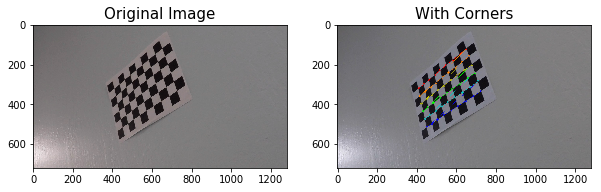

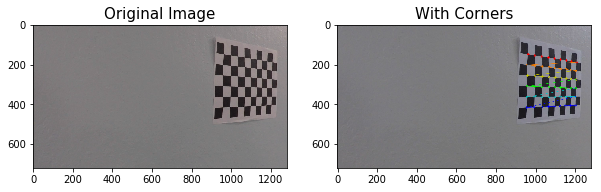

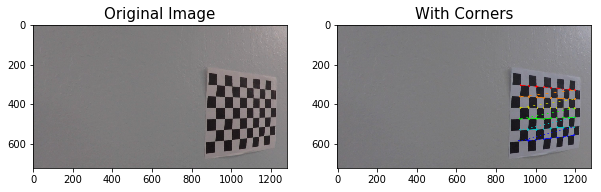

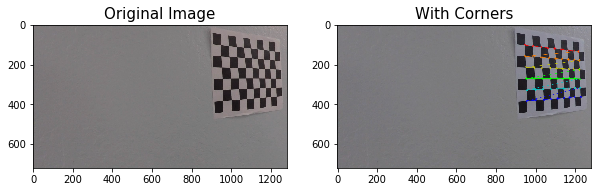

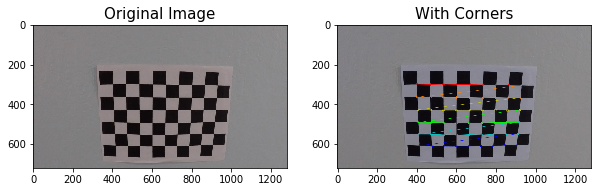

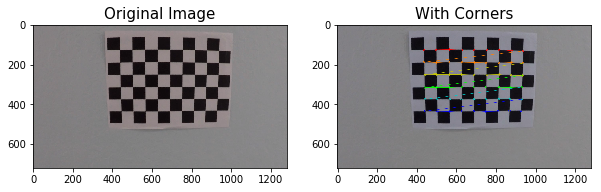

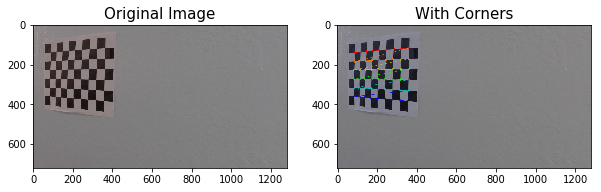

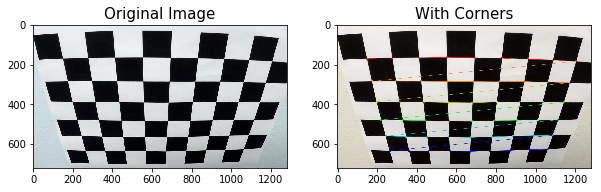

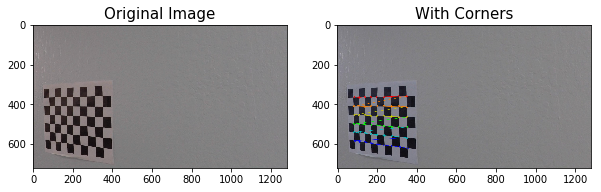

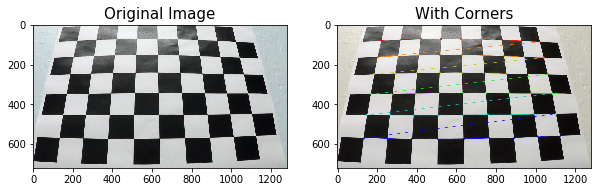

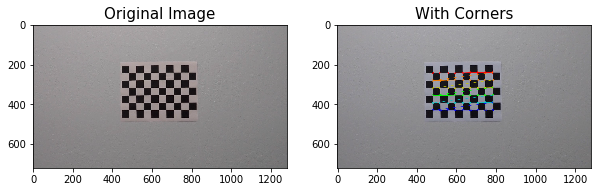

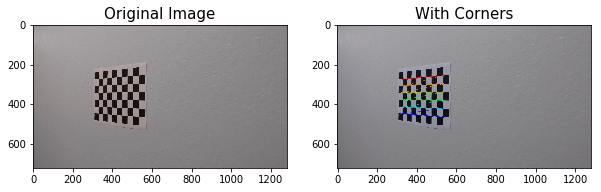

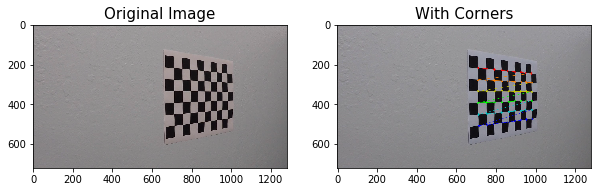

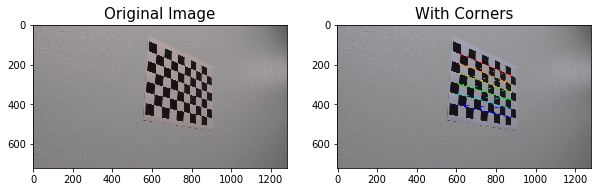

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Import, draw corners and display images
img_file_names = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6

for fname in img_file_names:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=15)

In [3]:
# Remove distortion from images
def undistort(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    return undist

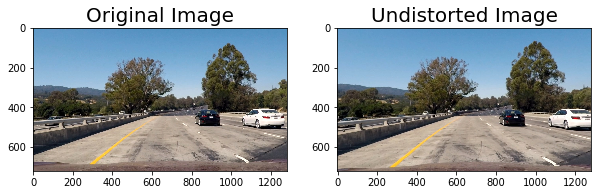

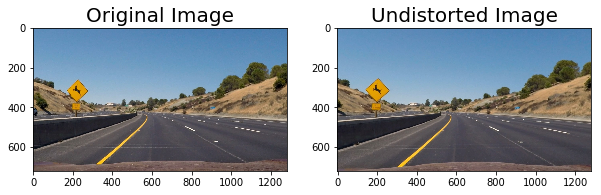

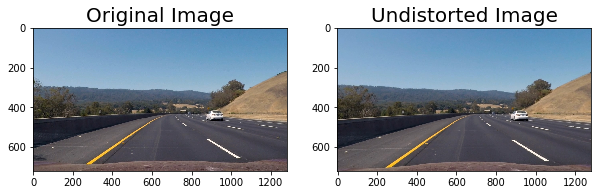

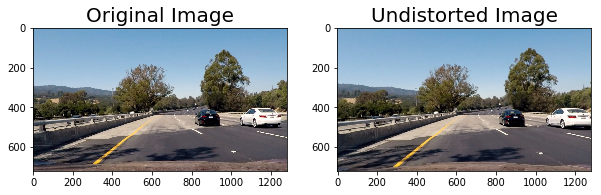

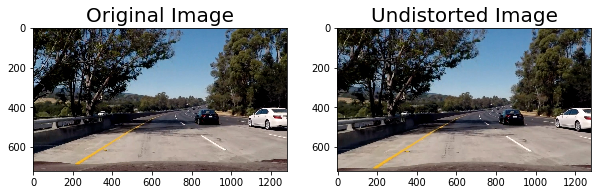

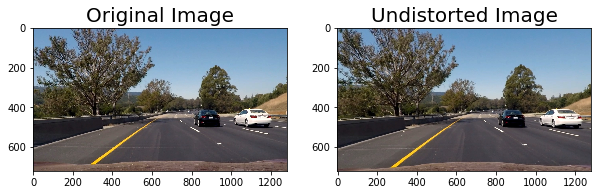

In [4]:
images = glob.glob('test_images/test[1-6].jpg')
for image in images:
    image = img = cv2.imread(image)
    undistort(image, True)

In [5]:
# Perform perspective transform
def persp_trans(undist_img, nx, ny, show=False):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    offset = 0
    src = np.float32([[450, 490],[790, 490],
                      [1200, 700],[100, 700]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist_img, M, img_size)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M

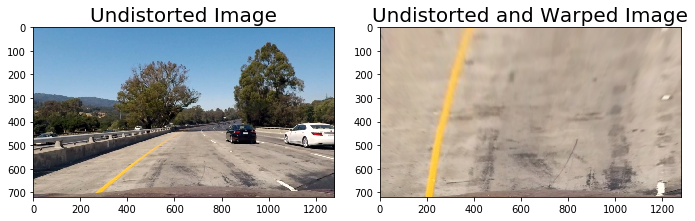

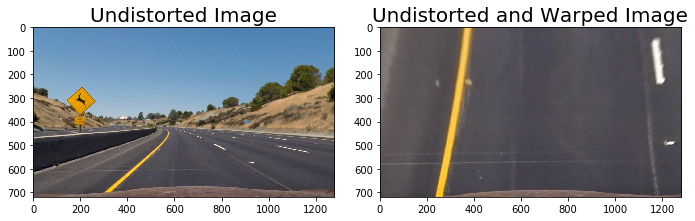

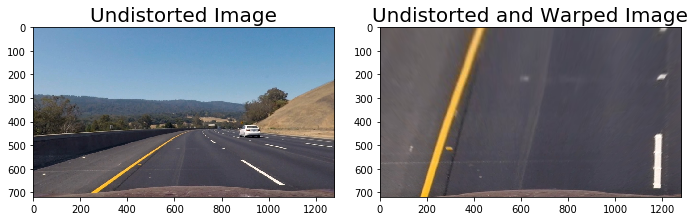

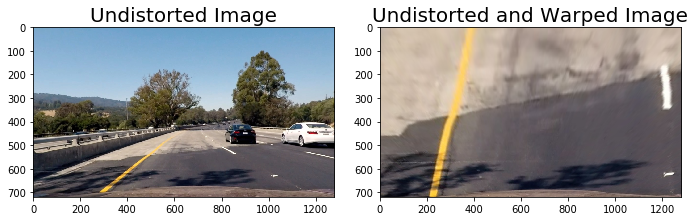

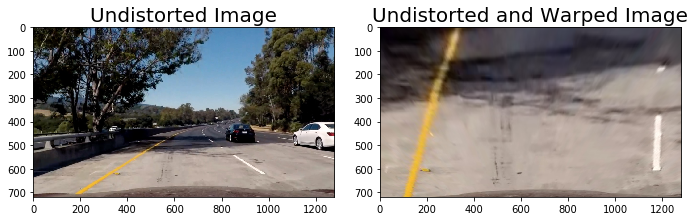

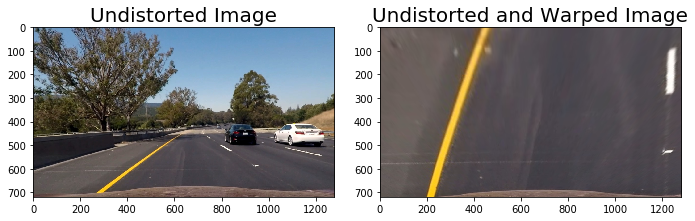

In [6]:
for img in glob.glob('test_images/test[1-6].jpg'):
    img = cv2.imread(img)
    undist_img = undistort(img)
    persp_trans(undist_img, nx, ny, show=True)

In [7]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(img, show=False):
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    h_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,0]
    
    r_channel = img[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 200
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    h_thresh_min = 21
    h_thresh_max = 50
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    
    r_thresh_min = 228
    r_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (r_binary == 1) | (h_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3, ax4,ax5, ax6)) = plt.subplots(1, 6, sharey='col', sharex='row', figsize=(20,2))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=7)
        ax1.imshow(cv2.cvtColor(undistort(image),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=7)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('S binary threshold', fontsize=7)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('H binary threshold', fontsize=7)
        ax4.imshow(h_binary, cmap='gray')
        
        ax5.set_title('R binary threshold', fontsize=7)
        ax5.imshow(r_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=7)
        ax6.imshow(combined_binary, cmap='gray')
    return combined_binary

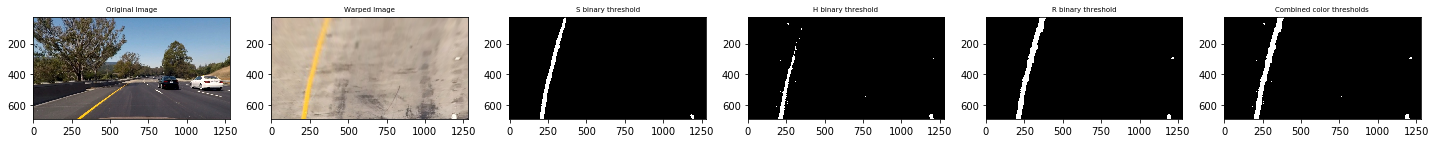

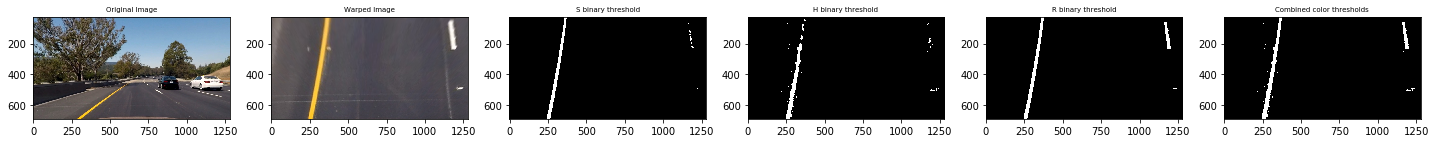

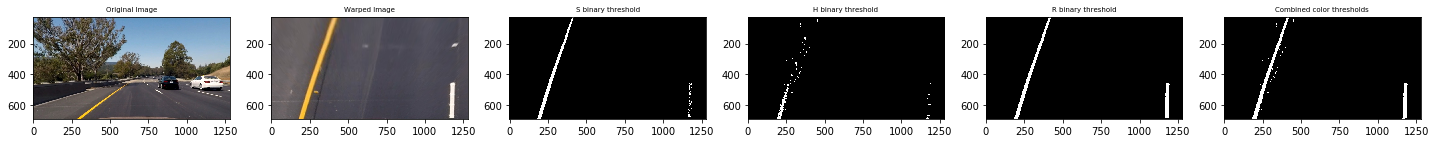

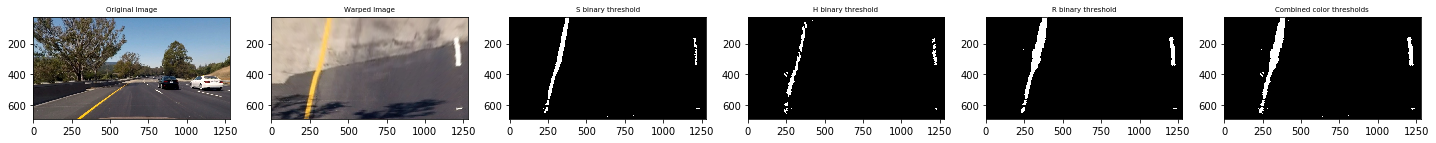

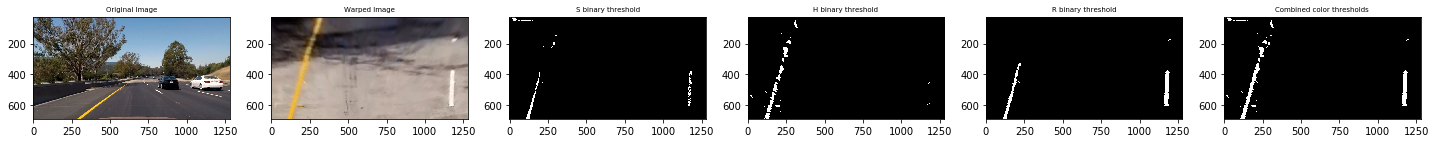

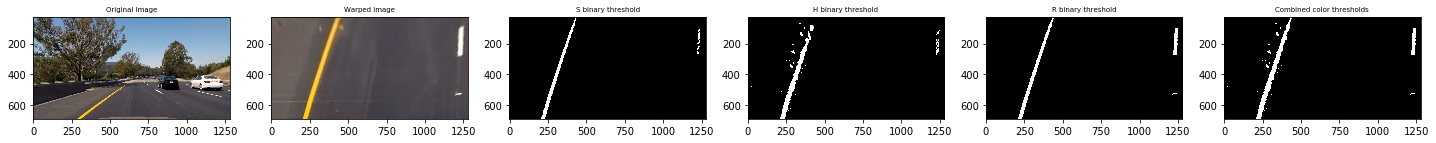

In [8]:
for img in glob.glob('test_images/test[1-6].jpg'):
    img = cv2.imread(img)
    undist_img = undistort(img)
    warped, M = persp_trans(undist_img, nx, ny)
    apply_thresholds(warped, show=True)

In [9]:
def fill_lane(combined_binary, show=False):
    height, width = combined_binary.shape
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined_binary[height//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    mid_point = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid_point])
    rightx_base = np.argmax(histogram[mid_point:]) + mid_point
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(height/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzerox = np.array(nonzero)[1]
    nonzeroy = np.array(nonzero)[0]
    for window in range(nwindows):
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        #cv2.rectangle(out_img, (win_leftx_low,win_y_low), (win_leftx_high,win_y_high), (0,255,0), 2)
        #cv2.rectangle(out_img, (win_rightx_low,win_y_low), (win_rightx_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_leftx_low) & (nonzerox <= win_leftx_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_rightx_low) & (nonzerox <= win_rightx_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0])

    # Extract left and right lane pixel positions
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
            
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate the center of the lane
    center = (left_fitx[-1] + right_fitx[-1])/2
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 48/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Plot up the data
    if show:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()    
        ax1.imshow(cv2.cvtColor((persp_trans(undistort(image), nx, ny)[0]), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(720, 0)
        ax1.plot(left_fitx, ploty, color='green', linewidth=3)
        ax1.plot(right_fitx, ploty, color='green', linewidth=3)
        ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
        ax2.imshow(result)
        ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
        if center < 640:
            ax2.text(200, 100, '{:.2f}m left from center'.format(center*xm_per_pix),
                     style='italic', color='white', fontsize=10, position=(450,300))
        else:
            ax2.text(200, 100, '{:.2f}m right from center'.format(center*xm_per_pix),
                     style='italic', color='white', fontsize=10, position=(450,300))
        ax2.text(200, 175, 'Radius of curvature: {}m'.format(int((left_curverad + right_curverad)/2)),
                 style='italic', color='white', fontsize=10, position=(400,340))
    return ploty, left_fitx, right_fitx

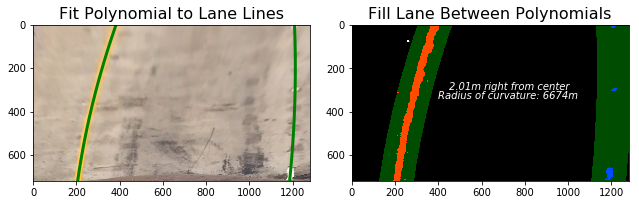

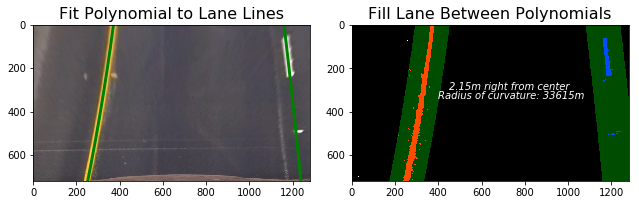

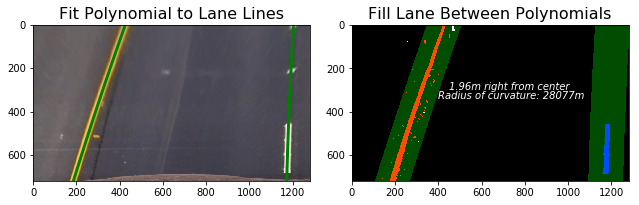

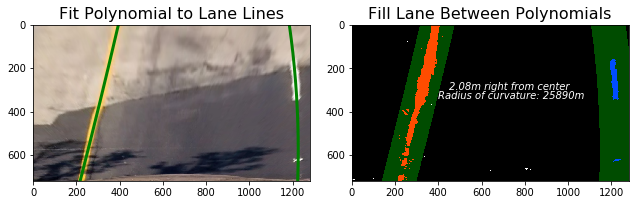

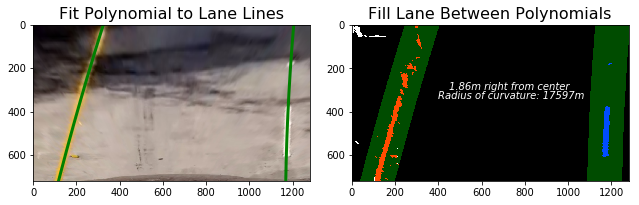

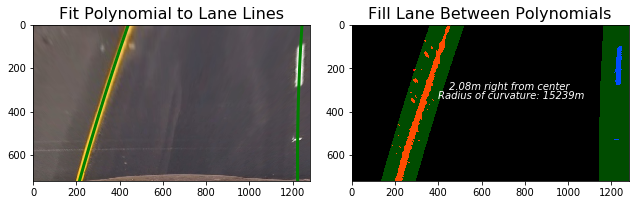

In [10]:
for image in glob.glob('test_images/test[1-6].jpg'):
    image = cv2.imread(image)
    undist_img = undistort(image)
    warped, M = persp_trans(undist_img, nx, ny, show=False)
    combined_binary = apply_thresholds(warped)
    fill_lane(combined_binary, show=True)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
# Checking that they have similar curvature
# Checking that they are separated by approximately the right distance horizontally
# Checking that they are roughly parallel

In [21]:
# Video Processing Pipeline
def process_vid(image, show=False):
    undist = undistort(image)
    warped, M = persp_trans(undist, nx, ny, show=False)
    Minv = np.linalg.inv(M)
    combined_binary = apply_thresholds(warped)
    ploty, left_fitx, right_fitx = fill_lane(combined_binary)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    if show:
        plot_img = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
        f, ax1 = plt.subplots(1,1,figsize=(9,6))
        f.tight_layout()
        ax1.imshow(plot_img)
    return result

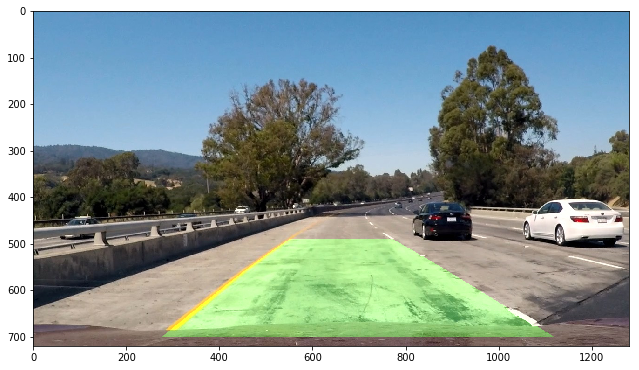

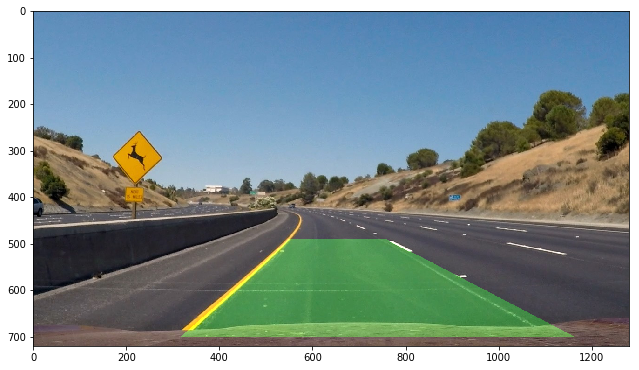

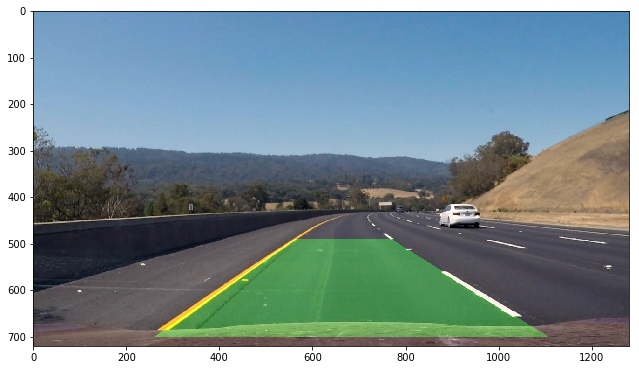

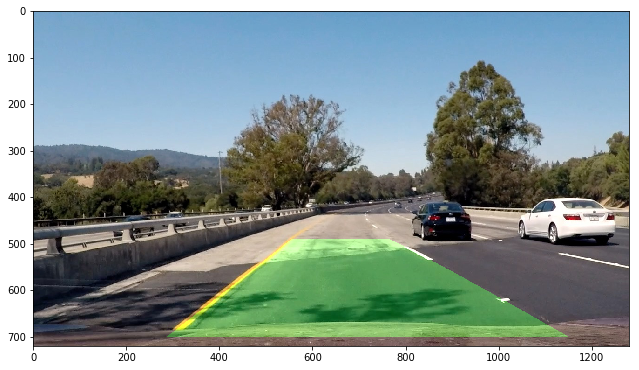

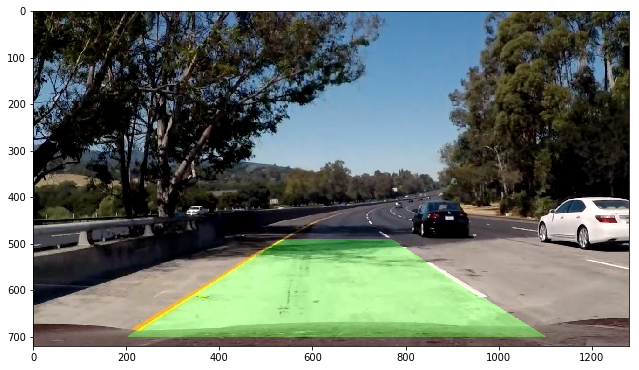

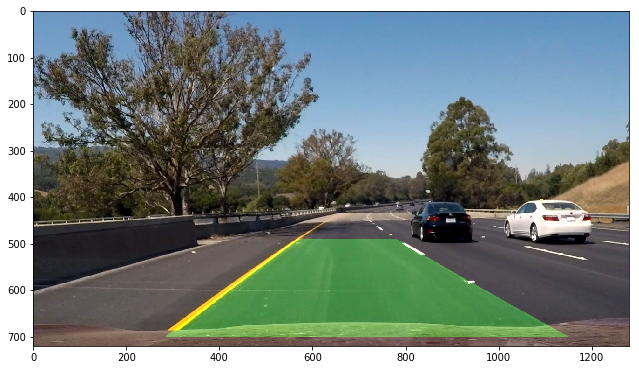

In [22]:
for image in glob.glob('test_images/test[1-6].jpg'):
    image = cv2.imread(image)
    process_vid(image, show=True)

In [27]:
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_vid)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 48%|█████████████████████████████████████▌                                         | 600/1261 [08:48<09:08,  1.20it/s]

TypeError: expected non-empty vector for x

In [24]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [26]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid).subclip(0,2)
challenge_clip.write_videofile(challenge_output, audio=False)

TypeError: expected non-empty vector for x

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))